<a href="https://colab.research.google.com/github/ds4ph-bme/ds4ph-spring-2022-hw-8-HerambGupta/blob/main/Homework_8_DS4PH_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8 DS4PH 2022
1. Get the country-specific covid case data from [here](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv). (Note pandas allows you to load a csv file from a URL. Make sure to use the "raw" link to the file on github.). Pick a country. Let $Y_t$ be the case count for day $t$ since the outbreak onset for that country. That is, process the time series so that $t=0$ is the first day with more than 0 cases. Then, fit a distributed lag linear model as follows.  
$$
Y_t = \alpha_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_k Y_{t-5} + \epsilon_t
$$ 
That is, see how the last five days predicts the current day. Report and interpret the coefficients.
2. Refer to the previous question. Let A and B be your two countries. Create a plot of time versus prediction error for the following: 
  a. fit the model on (all of) A and apply it to (all of) A, 
  b. fit A on the first half of the time for A, apply it to all of A.
This contrasts the forecasting error, a model fit using prior data applied to future data that didn't get to impact the fitting, with the training error.  
3. Plot the errors over time for applying the model from country A and applying it to a new country, B that you pick. This is out of sample error.
4. Consider the covid data from the previous questions. Let $Z_t = I(Y_t > Y_{t-1})$. That is, $Z_t$ is 1 if cases went up on day $t$ and $0$ otherwise.  Consider the following Markovian logit model:
$$
\mathrm{logit}\{P(Z_t = 1)\} = \alpha_0 + \beta_1 Z_{t-1} + \beta_2 Z_{t-2} + \beta_3 Z_{t-3} + \beta_4 Z_{t-4}+\beta_4 Z_{t-5}
$$
In other words, how does whether or not the previous five days case values predict whether or not the number of cases will go up or down? Report and interpret your coefficients. 


In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from datetime import datetime as dt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part 1

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [3]:
#Extracting cases for India

india=data.loc[data['Country/Region']=='India']
india=india.drop(['Province/State','Country/Region','Lat','Long'],axis=1)
india=india.transpose()
india.reset_index(level=0, inplace=True)
india.columns=['Date','Cases']
india=india.loc[india.Cases>0]

#Converting Cumulative Counts to Daily Cases

arr=np.zeros(india.shape[0])
arr[0]=india.iloc[0,1]
for i in range(1,india.shape[0]):
  arr[i]=int(india.iloc[i,1]-india.iloc[i-1,1])

india['Cases']=arr

#Converting Dates to Date time variable for ease of plotting
for i in range(india.shape[0]):
  india.Date.iloc[i]=dt.strptime(india.Date.iloc[i],"%m/%d/%y")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
india

,Date,Cases
8,2020-01-30 00:00:00,1.0
9,2020-01-31 00:00:00,0.0
10,2020-02-01 00:00:00,0.0
11,2020-02-02 00:00:00,1.0
12,2020-02-03 00:00:00,1.0
...,...,...
805,2022-04-06 00:00:00,1033.0
806,2022-04-07 00:00:00,1109.0
807,2022-04-08 00:00:00,1150.0
808,2022-04-09 00:00:00,1054.0


In [5]:
#Function to create lag

def lag(arr,n):
    s=len(arr)
    for i in range(1,s-n+1):
        arr[s-i]=arr[s-i-n]
        
    for i in range(n):
        arr[i]=0
    
    return arr

In [6]:
#Adding Last 5 days cases.

c=india.Cases.to_numpy().copy()
l=lag(c,1)
india['Cases_1']=l

c=india.Cases.to_numpy().copy()
l=lag(c,2)
india['Cases_2']=l

c=india.Cases.to_numpy().copy()
l=lag(c,3)
india['Cases_3']=l

c=india.Cases.to_numpy().copy()
l=lag(c,4)
india['Cases_4']=l

c=india.Cases.to_numpy().copy()
l=lag(c,5)
india['Cases_5']=l

In [7]:
#Seeing how the last five days predicts the current day

results = smf.ols('Cases ~ Cases_1 + Cases_2 + Cases_3  + Cases_4 + Cases_5', data = india).fit()
print(results.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.990     
Dependent Variable: Cases            AIC:                16695.8846
Date:               2022-04-11 05:35 BIC:                16724.0073
No. Observations:   802              Log-Likelihood:     -8341.9   
Df Model:           5                F-statistic:        1.636e+04 
Df Residuals:       796              Prob (F-statistic): 0.00      
R-squared:          0.990            Scale:              6.3878e+07
--------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
Intercept  448.7755  339.3107   1.3226  0.1863  -217.2739  1114.8250
Cases_1      1.2514    0.0354  35.3898  0.0000     1.1820     1.3208
Cases_2     -0.3322    0.0566  -5.8685  0.0000    -0.4433    -0.2211
Cases_3      0.2430    0.0572   4.2495  0.0000     0.1307   

We see that $\beta_0 = 451.4232$, $\beta_1=1.2513$, $\beta_2=-0.3322$, $\beta_3=0.2430$, $\beta_4=-0.1012$, $\beta_5=-0.0693$. This tells us that, the prediction of number of cases on a day increases if the number of cases on 1 and/or 3 before increases, and decreases if the number of cases on day 2,4 and/or 5 before increases.

# Part 2

In [8]:
#Predicting India on all of India

y = india.Cases
x = india.drop(['Date', 'Cases'], axis=1)
fit_all = LinearRegression().fit(x, y)
yhat = fit_all.predict(x)

Text(0, 0.5, 'Date')

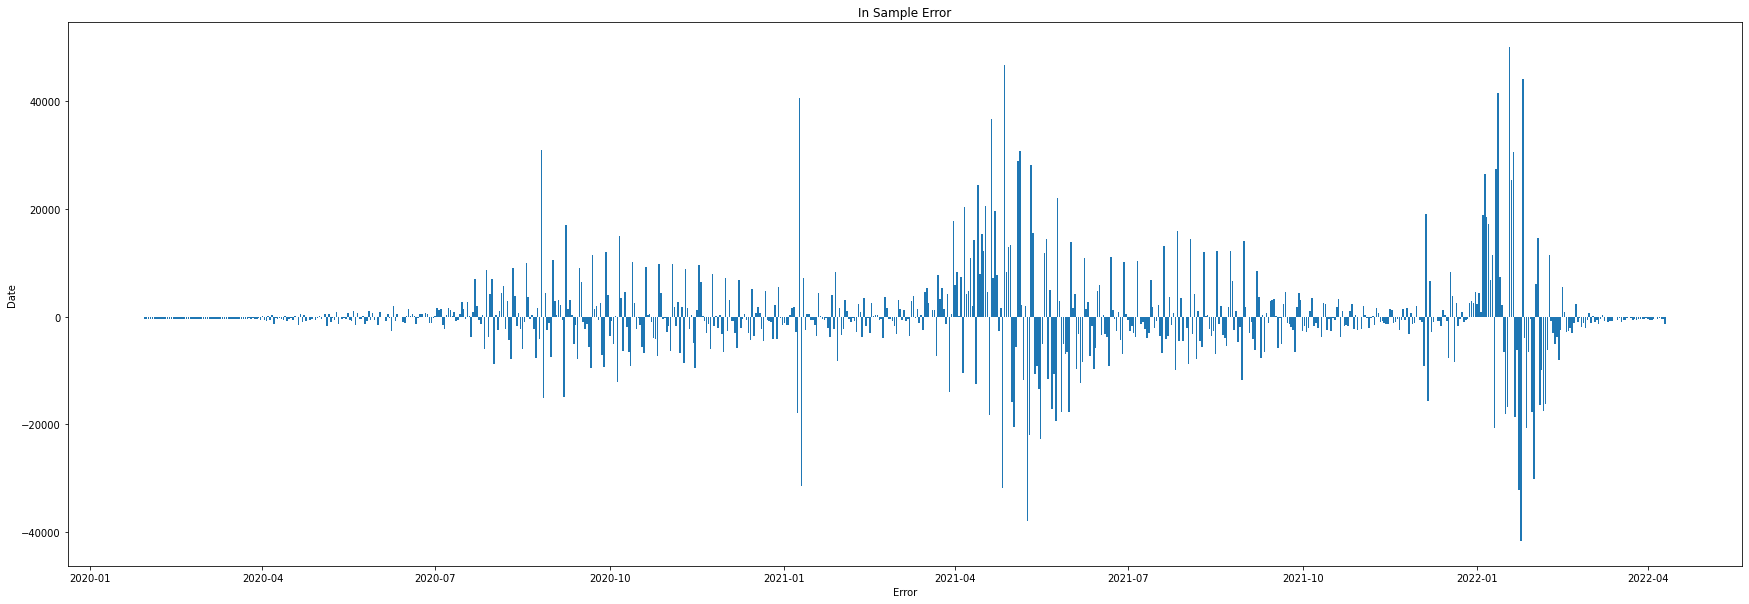

In [9]:
fig=plt.figure(figsize=(30,10))
plt.bar(india.Date,y-yhat)
plt.title("In Sample Error")
plt.xlabel("Error")
plt.ylabel("Date")

In [10]:
#Predicting Later Half of India on First Half of India

y_train=india.Cases.iloc[0:int(len(y)/2)]
x_train=india.drop(['Date', 'Cases'], axis=1).iloc[0:int(len(y)/2),:]
y_test=india.Cases.iloc[int(len(y)/2):]
x_test=india.drop(['Date', 'Cases'], axis=1).iloc[int(len(y)/2):,:]

Text(0, 0.5, 'Date')

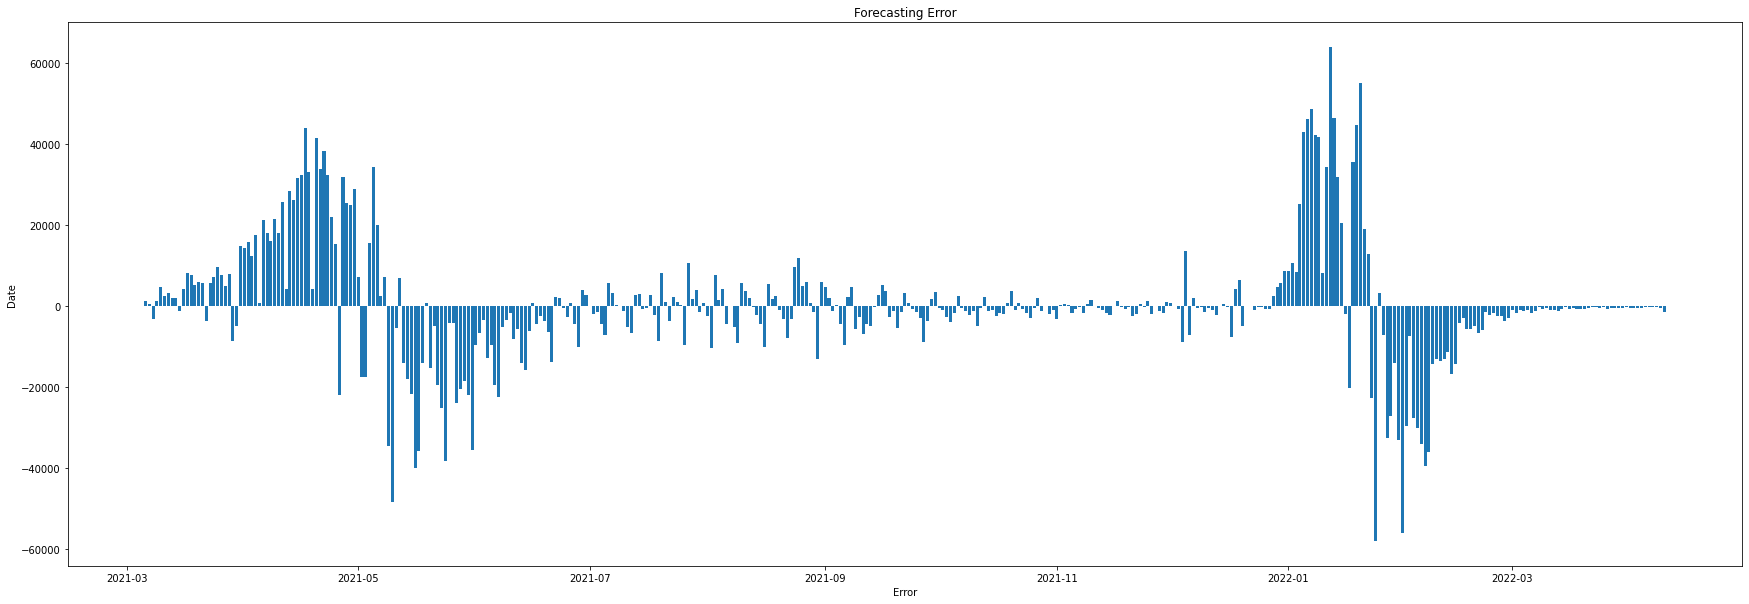

In [11]:
fit_part = LinearRegression().fit(x_train, y_train)
yhat = fit_part.predict(x_test)
fig=plt.figure(figsize=(30,10))
plt.bar(india.Date.iloc[int(len(y)/2):],y_test-yhat)
plt.title("Forecasting Error")
plt.xlabel("Error")
plt.ylabel("Date")

# Part 3

In [12]:
#Extracting cases for Nepal

nepal=data.loc[data['Country/Region']=='Nepal']
nepal=nepal.drop(['Province/State','Country/Region','Lat','Long'],axis=1)
nepal=nepal.transpose()
nepal.reset_index(level=0, inplace=True)
nepal.columns=['Date','Cases']
nepal=nepal.loc[nepal.Cases>0]

arr=np.zeros(nepal.shape[0])
arr[0]=nepal.iloc[0,1]
for i in range(1,nepal.shape[0]):
  arr[i]=int(nepal.iloc[i,1]-nepal.iloc[i-1,1])

nepal['Cases']=arr

#Converting Dates to Date time variable for ease of plotting
for i in range(nepal.shape[0]):
  nepal.Date.iloc[i]=dt.strptime(nepal.Date.iloc[i],"%m/%d/%y")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
#Adding Last 5 days cases.

c=nepal.Cases.to_numpy().copy()
l=lag(c,1)
nepal['Cases_1']=l

c=nepal.Cases.to_numpy().copy()
l=lag(c,2)
nepal['Cases_2']=l

c=nepal.Cases.to_numpy().copy()
l=lag(c,3)
nepal['Cases_3']=l

c=nepal.Cases.to_numpy().copy()
l=lag(c,4)
nepal['Cases_4']=l

c=nepal.Cases.to_numpy().copy()
l=lag(c,5)
nepal['Cases_5']=l

In [14]:
y_nepal=nepal.Cases
x_nepal=nepal.drop(['Date', 'Cases'], axis=1)
yhat = fit_all.predict(x_nepal)

Text(0.5, 0, 'Date')

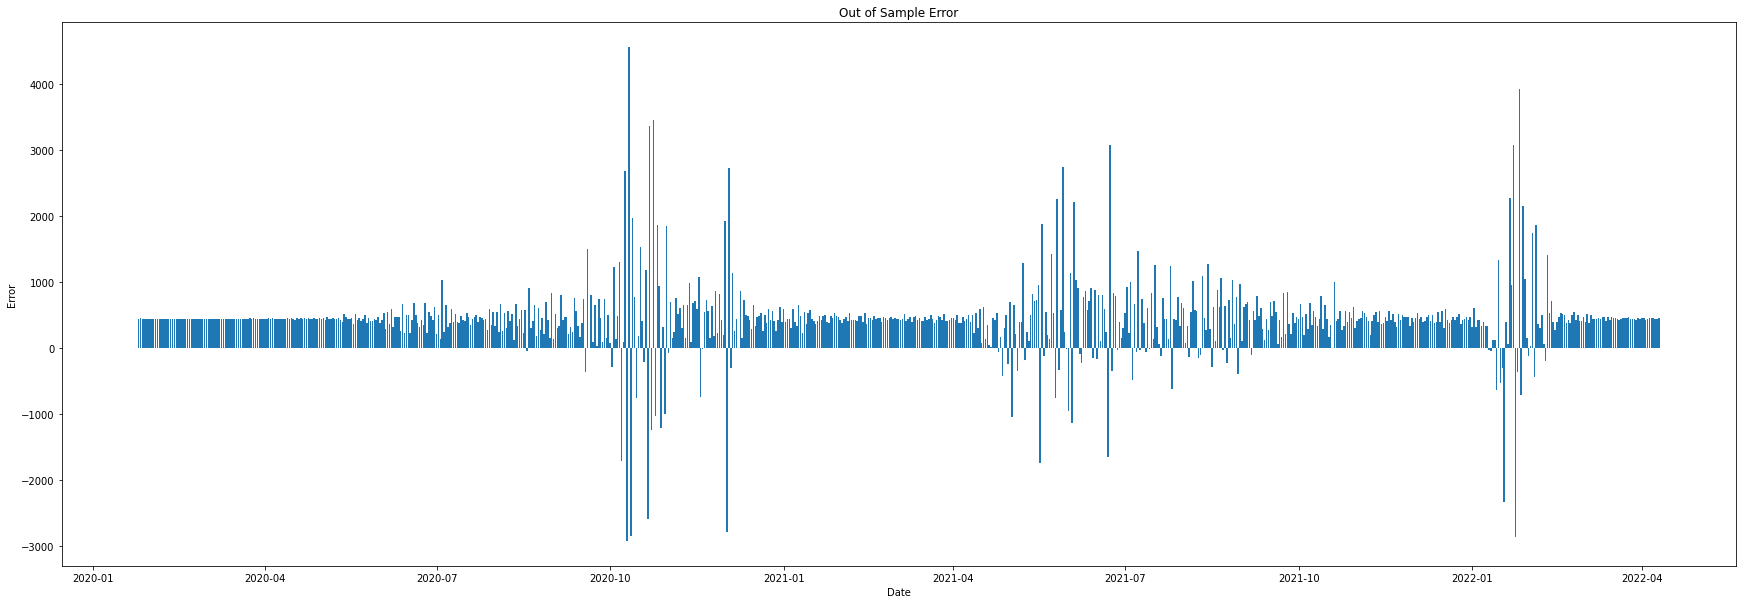

In [15]:
fig=plt.figure(figsize=(30,10))
plt.bar(nepal.Date,yhat-y_nepal)
plt.title("Out of Sample Error")
plt.ylabel("Error")
plt.xlabel("Date")

# Part 4

In [16]:
# Adding day 6 for India and Nepal to calculate Z(t-5)

c=nepal.Cases.to_numpy().copy()
l=lag(c,6)
nepal['Cases_6']=l

c=india.Cases.to_numpy().copy()
l=lag(c,6)
india['Cases_6']=l

In [17]:
u='Zt'
sub=['zero','one','two','three','four','five']
for i in range(1,7):
  h=nepal.iloc[:,i]>nepal.iloc[:,i+1]
  g=h*1
  nepal[u+sub[i-1]]=g

for i in range(1,7):
  h=india.iloc[:,i]>india.iloc[:,i+1]
  g=h*1
  india[u+sub[i-1]]=g  

In [18]:
nepal_model=smf.logit('Ztzero ~ Ztone + Zttwo + Ztthree + Ztfour + Ztfive',data=nepal).fit()
india_model=smf.logit('Ztzero ~ Ztone + Zttwo + Ztthree + Ztfour + Ztfive',data=india).fit()

Optimization terminated successfully.
         Current function value: 0.673948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673384
         Iterations 4


In [19]:
nepal_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.022     
Dependent Variable: Ztzero           AIC:              1099.7516 
Date:               2022-04-11 05:36 BIC:              1127.9116 
No. Observations:   807              Log-Likelihood:   -543.88   
Df Model:           5                LL-Null:          -556.24   
Df Residuals:       801              LLR p-value:      0.00015687
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.5287    0.1614  -3.2758  0.0011  -0.8449  -0.2124
Ztone         -0.3515    0.1459  -2.4100  0.0160  -0.6374  -0.0656
Zttwo          0.3847    0.1459   2.6377  0.0083   0.0989   0.6706
Ztthree        0.2408    0.1467   1.6415  0.1007  -0.0467   0.5283
Ztfour         0.0916    0.1462   0.6267  0.5309  -0.1949   0.3782
Ztfive         0.4002    0.1454   2.7518  0.0059   0.1152   0.6853
=================================================================

"""

In [20]:
india_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.023     
Dependent Variable: Ztzero           AIC:              1092.1084 
Date:               2022-04-11 05:36 BIC:              1120.2311 
No. Observations:   802              Log-Likelihood:   -540.05   
Df Model:           5                LL-Null:          -553.02   
Df Residuals:       796              LLR p-value:      9.2187e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.3948    0.1518  -2.6011  0.0093  -0.6923  -0.0973
Ztone          0.6197    0.1473   4.2075  0.0000   0.3310   0.9084
Zttwo         -0.3332    0.1491  -2.2349  0.0254  -0.6255  -0.0410
Ztthree        0.2712    0.1487   1.8235  0.0682  -0.0203   0.5628
Ztfour         0.1261    0.1485   0.8493  0.3957  -0.1649   0.4171
Ztfive        -0.2039    0.1471  -1.3860  0.1658  -0.4922   0.0844
=================================================================

"""

Here in both the models we see that the Pseudo R-Squared is very low, thus we can say that some variables are not contributing to both the models' R-squared properly.

We can see that in both the models, the cases one, two and three days before have a low p value, this tells us that there is a high chance that these three variables have a significant impact on the number of cases on any given day.